In [1]:
import matplotlib.pyplot as plt
import matplotlib.animation
%matplotlib ipympl
import numpy as np
import pandas as pd

from scipy.spatial import KDTree, cKDTree
from scipy.ndimage import uniform_filter1d
from scipy.signal import savgol_filter
from scipy.optimize import curve_fit

import joblib
import time
from numba_progress import ProgressBar
from tqdm import tqdm
import trackpy as tp
from numba import njit, prange

from yupi import Trajectory
import yupi.graphics as yg
import yupi.stats as ys

from utility import get_imsd, get_imsd_windowed, get_emsd, get_emsd_windowed, fit_hist, MB_2D,\
                    normal_distr, get_trajs, speed_windowed, theta_windowed, get_smooth_trajs, get_velocities

show_verb = False
save_verb = True
anim_show_verb = False

In [2]:
rawTrajs = pd.read_parquet("../tracking/results/pre_merge_tracking.parquet")
red_particle_idx = 17
rawTrajs.loc[rawTrajs.particle != red_particle_idx, ["color"]] = "#00007F"
rawTrajs.loc[rawTrajs.particle == red_particle_idx, ["color"]] = "#FF0000"
colors = rawTrajs.loc[rawTrajs.frame == 0, 'color'].values
nDrops = len(rawTrajs.loc[rawTrajs.frame==0])
nFrames = max(rawTrajs.frame) + 1
print(f"nDrops:{nDrops}")
print(f"nFrames:{nFrames} --> {nFrames/10:.2f} s")


# WINDOWED ANALYSIS PARAMETERS
window = 3200 # 320 s
stride = 100 # 10 s
print(f"window of {window/10} s, stride of {stride/10} s")
startFrames = np.arange(0, nFrames-window, stride, dtype=int)
endFrames = startFrames + window
nSteps = len(startFrames)
print(f"number of steps: {nSteps}")


# step 10 with a 10 fps video --> 1 s
units = "px/s"
default_kwargs_blue = {"color": "#00FFFF", "ec": (0, 0, 0, 0.6), "density": True}
default_kwargs_red = {"color": "#EE4B2B", "ec": (0, 0, 0, 0.6), "density": True}
    
maxLagtime = 1000
#x = np.arange(0.1, 100.1, 0.1) # without initial point
x = np.arange(0, 100, 0.1) # with initial point

blueTrajs, redTraj = get_trajs(nDrops, red_particle_idx, rawTrajs)

nDrops:50
nFrames:32000 --> 3200.00 s
window of 320.0 s, stride of 10.0 s
number of steps: 288


# MEAN SQUARED ANGULAR DIFFERENCE

In [ ]:
def get_msad(maxLagtime, r):
    current_msd = np.empty(maxLagtime)
    for lag_ in prange(1, maxLagtime + 1):
        x_ = np.sum(r[lag_:] * r[:-lag_], axis=1) / (np.linalg.norm(r[lag_:], axis=1)*np.linalg.norm(r[:-lag_], axis=1))
        temp = np.arccos( np.clip(x_, -1, 1) )
        current_msd[lag_ - 1] = np.mean(temp)
    return current_msd

In [ ]:
# mean squared angular displacement 
blueTrajs, redTraj = get_trajs(nDrops, red_particle_idx, rawTrajs)
maxLagtime = 1000
msad = np.empty((len(blueTrajs), maxLagtime))
for i in tqdm(range(len(blueTrajs))):
    r = np.array(blueTrajs[i].r)
    current_msd = get_msad(maxLagtime, r)
    msad[i] = current_msd
msad_b = np.mean(msad, axis=0)
msad_b_std = np.std(msad, axis=0)

msad_r = get_msad(maxLagtime, np.array(redTraj[0].r))

100%|██████████| 49/49 [01:21<00:00,  1.66s/it]


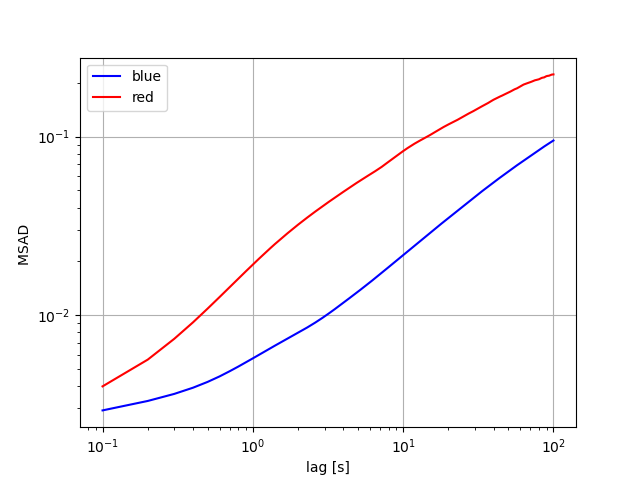

In [ ]:
fig, ax = plt.subplots()
ax.plot(np.arange(1, maxLagtime+1, 1)/10, msad_b, 'b', label="blue")
ax.plot(np.arange(1, maxLagtime+1, 1)/10, msad_r, 'r', label="red")
ax.legend()
ax.grid()
ax.set(xlabel="lag [s]", ylabel="MSAD ", xscale="log", yscale="log")
plt.show()

# VELOCITY CORRELATION

In [4]:
@njit(parallel=True, fastmath=True)
def get_corr(velocities, maxLagtime_):
    xx = np.zeros((velocities.shape[0], maxLagtime_))
    yy = np.zeros((velocities.shape[0], maxLagtime_))
    xy = np.zeros((velocities.shape[0], maxLagtime_))
    for i in prange(velocities.shape[0]):
        v = velocities[i]
        xx[i, 0] = np.corrcoef(v[0], v[0])[0, 1]
        yy[i, 0] = np.corrcoef(v[1], v[1])[0, 1]
        xy[i, 0] = np.corrcoef(v[0], v[1])[0, 1]
        
        for lag_ in prange(1, maxLagtime_):
            xx[i, lag_] = np.corrcoef(v[0, :-lag_], v[0, lag_:])[0, 1]
            yy[i, lag_] = np.corrcoef(v[1, :-lag_], v[1, lag_:])[0, 1]
            xy[i, lag_] = np.corrcoef(v[0, :-lag_], v[1, lag_:])[0, 1]
    return xx, yy, xy

def corr_windowed(nSteps, maxLagtime, startFrames, endFrames, trajectories, red_particle_idx, nDrops):
    corr_b = np.zeros((nSteps, 3, maxLagtime))
    corr_std_b = np.zeros((nSteps, 3, maxLagtime))
    corr_r = np.zeros((nSteps, 3, maxLagtime))
    corr_std_r = np.zeros((nSteps, 3, maxLagtime))

    for k in tqdm(range(nSteps)):
        trajs = trajectories.loc[trajectories.frame.between(startFrames[k], endFrames[k])]
        blueTrajs, redTraj = get_trajs(nDrops, red_particle_idx, trajs)

        res = np.array(get_corr(get_velocities(blueTrajs), maxLagtime))
        corr_b[k], corr_std_b[k] = res.mean(axis=1), res.std(axis=1)
        
        res = np.array(get_corr(get_velocities(redTraj), maxLagtime))
        corr_r[k], corr_std_r[k] = res.mean(axis=1), res.std(axis=1)

    return corr_b, corr_std_b, corr_r, corr_std_r

In [13]:
if 0:
    maxLagtime = 300
    corr_b, corr_std_b, corr_r, corr_std_r = corr_windowed(nSteps, maxLagtime, startFrames, endFrames, rawTrajs, red_particle_idx, nDrops)

    windLenght = 10
    polyOrder = 2
    smoothTrajs = get_smooth_trajs(rawTrajs, nDrops, windLenght, polyOrder)
    corr_b_smooth, corr_std_b_smooth, corr_r_smooth, corr_std_r_smooth = corr_windowed(nSteps, maxLagtime, startFrames, endFrames, smoothTrajs, red_particle_idx, nDrops)
    if 1:
        path = "./analysis_data/corr/raw/"
        pd.DataFrame(corr_b[:,0]).to_csv(path+"corr_b_x.csv", index=False)
        pd.DataFrame(corr_b[:,1]).to_csv(path+"corr_b_y.csv", index=False)
        pd.DataFrame(corr_b[:,2]).to_csv(path+"corr_b_xy.csv", index=False)
        pd.DataFrame(corr_std_b[:,0]).to_csv(path+"corr_std_b_x.csv", index=False)
        pd.DataFrame(corr_std_b[:,1]).to_csv(path+"corr_std_b_y.csv", index=False)
        pd.DataFrame(corr_std_b[:,2]).to_csv(path+"corr_std_b_xy.csv", index=False)
        pd.DataFrame(corr_r[:,0]).to_csv(path+"corr_r_x.csv", index=False)
        pd.DataFrame(corr_r[:,1]).to_csv(path+"corr_r_y.csv", index=False)
        pd.DataFrame(corr_r[:,2]).to_csv(path+"corr_r_xy.csv", index=False)
        pd.DataFrame(corr_std_r[:,0]).to_csv(path+"corr_std_r_x.csv", index=False)
        pd.DataFrame(corr_std_r[:,1]).to_csv(path+"corr_std_r_y.csv", index=False)
        pd.DataFrame(corr_std_r[:,2]).to_csv(path+"corr_std_r_xy.csv", index=False)

        path = "./analysis_data/corr/smooth/"
        text_file = open(path+"specs.txt", "w")
        n = text_file.write(f'Window size: {windLenght}, polyorder: {polyOrder}')
        text_file.close()

        pd.DataFrame(corr_b_smooth[:,0]).to_csv(path+"corr_b_x.csv", index=False)
        pd.DataFrame(corr_b_smooth[:,1]).to_csv(path+"corr_b_y.csv", index=False)
        pd.DataFrame(corr_b_smooth[:,2]).to_csv(path+"corr_b_xy.csv", index=False)
        pd.DataFrame(corr_std_b_smooth[:,0]).to_csv(path+"corr_std_b_x.csv", index=False)
        pd.DataFrame(corr_std_b_smooth[:,1]).to_csv(path+"corr_std_b_y.csv", index=False)
        pd.DataFrame(corr_std_b_smooth[:,2]).to_csv(path+"corr_std_b_xy.csv", index=False)
        pd.DataFrame(corr_r_smooth[:,0]).to_csv(path+"corr_r_x.csv", index=False)
        pd.DataFrame(corr_r_smooth[:,1]).to_csv(path+"corr_r_y.csv", index=False)
        pd.DataFrame(corr_r_smooth[:,2]).to_csv(path+"corr_r_xy.csv", index=False)
        pd.DataFrame(corr_std_r_smooth[:,0]).to_csv(path+"corr_std_r_x.csv", index=False)
        pd.DataFrame(corr_std_r_smooth[:,1]).to_csv(path+"corr_std_r_y.csv", index=False)
        pd.DataFrame(corr_std_r_smooth[:,2]).to_csv(path+"corr_std_r_xy.csv", index=False)
else:
    type_list = ["x", "y", "xy"]
    path = "./analysis_data/corr/raw/"
    corr_b = np.zeros((nSteps, 3, maxLagtime))
    corr_b_std = np.zeros((nSteps, 3, maxLagtime))
    corr_r = np.zeros((nSteps, 3, maxLagtime))
    corr_r_std = np.zeros((nSteps, 3, maxLagtime))

    for i in range(3):
        corr_b[:, i] = pd.read_csv(path+f"corr_b_{type_list[i]}.csv").values
        corr_b_std[:, i] = pd.read_csv(path+f"corr_std_b_{type_list[i]}.csv").values
        corr_r[:, i] = pd.read_csv(path+f"corr_r_{type_list[i]}.csv").values
        corr_r_std[:, i] = pd.read_csv(path+f"corr_std_r_{type_list[i]}.csv").values

    path = "./analysis_data/corr/smooth/"
    corr_b_smooth = np.zeros((nSteps, 3, maxLagtime))
    corr_b_std_smooth = np.zeros((nSteps, 3, maxLagtime))
    corr_r_smooth = np.zeros((nSteps, 3, maxLagtime))
    corr_r_std_smooth = np.zeros((nSteps, 3, maxLagtime))
    for i in range(3):
        corr_b_smooth[:, i] = pd.read_csv(path+f"corr_b_{type_list[i]}.csv").values
        corr_b_std_smooth[:, i] = pd.read_csv(path+f"corr_std_b_{type_list[i]}.csv").values
        corr_r_smooth[:, i] = pd.read_csv(path+f"corr_r_{type_list[i]}.csv").values
        corr_r_std_smooth[:, i] = pd.read_csv(path+f"corr_std_r_{type_list[i]}.csv").values


100%|██████████| 288/288 [07:40<00:00,  1.60s/it]


In [29]:
type_list = ["x", "y", "xy"]
for i in range(3):
    fig = plt.figure(figsize = (8, 5))
    anim_running = True

    def onClick(event):
        global anim_running
        if anim_running:
            ani.event_source.stop()
            anim_running = False
        else:
            ani.event_source.start()
            anim_running = True

    def update_graph(step):
        title.set_text(f"Velocity autocorrelation {type_list[i]} - Raw Trajectories - window [{startFrames[step]/10} - {endFrames[step]/10}] s")
        line.set_ydata(corr_b[step, i])    
        line1.set_ydata(corr_r[step, i])
        line2.set_ydata(corr_b_smooth[step, i])
        line3.set_ydata(corr_r_smooth[step, i])
        return line, line1, line2, line3,

    ax = fig.add_subplot(211)
    title = ax.set_title(f"Velocity autocorrelation - Raw Trajectories - window [{startFrames[0]/10} - {endFrames[0]/10}] s")
    line, = ax.plot(np.arange(0, maxLagtime, 1)/10, corr_b[0, i], 'b', label = "blue")
    line1, = ax.plot(np.arange(0, maxLagtime, 1)/10, corr_r[0, i], 'r', label = "red")
    ax.set(ylabel = r'vacf [$(px/s)^2$]', xlabel = 'lag time $t$ [s]', xlim = (-1, 10), ylim = (-0.5, 1))
    ax.grid()
    ax.legend()

    ax1 = fig.add_subplot(212)
    ax1.set_title(f"Smooth Trajectories")
    line2, = ax1.plot(np.arange(0, maxLagtime, 1)/10, corr_b_smooth[0, i], 'b', label = "blue")
    line3, = ax1.plot(np.arange(0, maxLagtime, 1)/10, corr_r_smooth[0, i], 'r', label = "red")
    ax1.set(ylabel = r'vacf [$(px/s)^2$]', xlabel = 'lag time $t$ [s]', xlim = (-1, 10), ylim = (-0.5, 1))
    ax1.grid()
    ax1.legend()

    plt.tight_layout()
    fig.canvas.mpl_connect('button_press_event', onClick)
    ani = matplotlib.animation.FuncAnimation(fig, update_graph, nSteps, interval = 5, blit=False)
    if save_verb: ani.save(f'./results/corr/corr_{type_list[i]}.mp4', fps=30, extra_args=['-vcodec', 'libx264'])
    if show_verb:
        plt.show()
    else:
        plt.close()

16:02:32 [INFO] Animation.save using <class 'matplotlib.animation.FFMpegWriter'>
16:02:32 [INFO] MovieWriter._run: running command: ffmpeg -f rawvideo -vcodec rawvideo -s 800x500 -pix_fmt rgba -r 30 -loglevel error -i pipe: -vcodec h264 -pix_fmt yuv420p -vcodec libx264 -y ./results/corr/corr_x.mp4
16:03:09 [INFO] Animation.save using <class 'matplotlib.animation.FFMpegWriter'>
16:03:09 [INFO] MovieWriter._run: running command: ffmpeg -f rawvideo -vcodec rawvideo -s 800x500 -pix_fmt rgba -r 30 -loglevel error -i pipe: -vcodec h264 -pix_fmt yuv420p -vcodec libx264 -y ./results/corr/corr_y.mp4
16:03:37 [INFO] Animation.save using <class 'matplotlib.animation.FFMpegWriter'>
16:03:37 [INFO] MovieWriter._run: running command: ffmpeg -f rawvideo -vcodec rawvideo -s 800x500 -pix_fmt rgba -r 30 -loglevel error -i pipe: -vcodec h264 -pix_fmt yuv420p -vcodec libx264 -y ./results/corr/corr_xy.mp4


# difference from raw trajs

In [8]:
corr_b, corr_std_b = get_corr(get_velocities(blueTrajs), maxLagtime)
corr_r, corr_std_r = get_corr(get_velocities(redTraj), maxLagtime)

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [11]:
corr_b.shape

(3, 1000)

In [13]:
windList = np.linspace(3, 13, 10, dtype=int)

corr_b_smooth = np.zeros((len(windList), 3, maxLagtime))
corr_r_smooth = np.zeros((len(windList), 3, maxLagtime))
corr_std_b_smooth = np.zeros((len(windList), 3, maxLagtime))
corr_std_r_smooth = np.zeros((len(windList), 3, maxLagtime))
                            
for k in tqdm(range(10)):
    smoothTrajs = get_smooth_trajs(rawTrajs, nDrops, windList[k], 2)
    blueTrajs_smooth, redTraj_smooth = get_trajs(nDrops, red_particle_idx, smoothTrajs)
    v_b_smooth = get_velocities(blueTrajs_smooth)

    corr_b_smooth[k], corr_std_b_smooth[k] = get_corr(get_velocities(blueTrajs), maxLagtime)
    corr_r_smooth[k], corr_std_r_smooth[k] = get_corr(get_velocities(redTraj), maxLagtime)

100%|██████████| 10/10 [07:30<00:00, 45.07s/it]


In [ ]:
fig, (ax, ax1) = plt.subplots(1, 2, figsize=(10, 4))
for i in range(0, 10):
    ax.plot(x, corr[0] - corr_smooth[i, 0], '-b', alpha = 1/(i+1))
ax.set_xlim(-1, 4)
#ax.legend()
for i in range(0, 10):
    ax1.plot(x, corr[1] - corr_smooth[i, 1], 'b', alpha = 1/(i+1))
#ax1.legend()
ax1.set_xlim(-1, 4)
plt.show()

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].plot(x, A)
ax[0].fill_between(x, A - A_std, A + A_std, alpha=0.2)
ax[0].set(xlabel = "lagtime [s]", xlim=(-1, 20), title = "x")

ax[1].plot(x, B, label="y")
ax[1].fill_between(x, B - B_std, B + B_std, alpha=0.2)
ax[1].set(xlabel="lagtime [s]" , ylabel = "correlation", xlim=(-1, 20), title = "y")
plt.show()

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].plot(x, A_smooth)
ax[0].fill_between(x, A_smooth - A_std_smooth, A_smooth + A_std_smooth, alpha=0.2)
ax[0].set(xlabel = "lagtime [s]", xlim=(-1, 20), title = "x")

ax[1].plot(x, B_smooth, label="y")
ax[1].fill_between(x, B_smooth - B_std_smooth, B_smooth + B_std_smooth, alpha=0.2)
ax[1].set(xlabel="lagtime [s]" , ylabel = "correlation", xlim=(-1, 20), title = "y")
plt.show()
